<a href="https://colab.research.google.com/github/svetloffs/Python_exp/blob/master/Nural_networks/AlexNet/Stepik_DL_NN_CV_AlexNet_Exrcise_5_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels

X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

len(y_train), len(y_test)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


(60000, 10000)

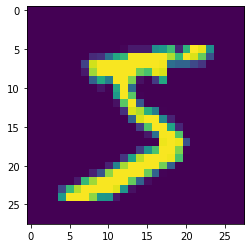

tensor(5)


In [3]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [4]:
# преобразуем сет в вид 60000х1х28х28
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

X_train.shape

torch.Size([60000, 1, 28, 28])

In [5]:
# создадим нашу сеть
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=12, kernel_size=5, padding=2)
        # self.act1  = torch.nn.Tanh()
        self.act1  = torch.nn.ELU()
        # self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=12, out_channels=60, kernel_size=5, padding=0)
        # self.act2  = torch.nn.Tanh()
        self.act2  = torch.nn.ELU()
        # self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = torch.nn.Conv2d(
            in_channels=60, out_channels=48, kernel_size=3, padding=2)
        # self.act3  = torch.nn.Tanh()
        self.act3  = torch.nn.ELU()
        # self.pool3 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(3 * 3 * 48, 120)
        # self.act4  = torch.nn.Tanh()
        self.act4  = torch.nn.ELU()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act5  = torch.nn.Tanh()
        # self.act5  = torch.nn.ELU()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [7]:
loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)
optimizer = torch.optim.SGD(params=lenet5.parameters(), lr=1.e-2, momentum=0.74) ### 0.75 - best acc = 0.9942

In [8]:
batch_size = 128
epochs = 200

In [9]:
# test_accuracy_history = [i for i in range(11)]
# np.median(np.array(test_accuracy_history[0:11])), np.mean(np.array(test_accuracy_history[0:11]))

In [ ]:
test_loss_history = []
test_accuracy_history = []
X_test = X_test.to(device)
y_test = y_test.to(device)
long_history = 50
for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    # из полученных данных оставим только значение accuracy и перенесем на CPU
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    print(epoch, end=' ')
    if epoch >= long_history and (np.array(test_accuracy_history[epoch - long_history: epoch]).mean() > test_accuracy_history[epoch]):
        print(np.array(test_accuracy_history[epoch - long_history: epoch]).max())
        print(test_accuracy_history[epoch])
        break
    if accuracy >= 0.992:
        print(accuracy)
print(np.array(test_accuracy_history).max())

0 1 2 3 4 5 6 7 8 tensor(0.9927)
9 tensor(0.9922)
10 tensor(0.9928)
11 tensor(0.9924)
12 tensor(0.9920)
13 tensor(0.9927)
14 tensor(0.9922)
15 tensor(0.9924)
16 tensor(0.9921)
17 tensor(0.9926)
18 tensor(0.9923)
19 tensor(0.9928)
20 tensor(0.9922)
21 tensor(0.9926)
22 tensor(0.9920)
23 tensor(0.9925)
24 tensor(0.9927)
25 tensor(0.9924)
26 tensor(0.9924)
27 tensor(0.9927)
28 tensor(0.9923)
29 tensor(0.9924)
30 tensor(0.9928)
31 tensor(0.9924)
32 tensor(0.9928)
33 tensor(0.9924)
34 tensor(0.9924)
35 tensor(0.9925)
36 tensor(0.9928)
37 tensor(0.9928)
38 tensor(0.9927)
39 tensor(0.9927)
40 tensor(0.9924)
41 tensor(0.9928)
42 tensor(0.9925)
43 tensor(0.9927)
44 tensor(0.9927)
45 tensor(0.9927)
46 tensor(0.9925)
47 tensor(0.9927)
48 tensor(0.9926)
49 tensor(0.9928)
50 tensor(0.9926)
51 tensor(0.9927)
52 tensor(0.9926)
53 tensor(0.9928)
54 tensor(0.9929)
55 tensor(0.9931)
56 tensor(0.9928)
57 tensor(0.9928)
58 tensor(0.9927)
59 tensor(0.9928)


In [ ]:
test_accuracy_history[5-10], test_accuracy_history[5], len(test_accuracy_history)

In [ ]:
lenet5.forward(X_test).size()

In [ ]:
y_test[0]

In [ ]:
plt.plot(test_loss_history);

In [ ]:
plt.plot(test_accuracy_history);